In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\user\appdata\local\programs\python\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
warnings.filterwarnings("ignore")

##  I. Goal

The notebook demonstrates examples for implementing models by instructing it how to arrive at the output 

## II.  Usecase 1: The model prediction must be a decreasing (or increasing) function of x1

In [11]:
def print_results(result):
     
    """
    The function takes in a fitted model and prints the best params and training and test set performance 
    """
    
    print("XGB Model best params : {}".format(result.best_params_))
    
    ypred_train = result.predict(X_train)
    mse_train = mean_squared_error(y_train, ypred_train)
    print(" Train RMSE: %.5f" % (mse_train**(1/2.0)))
    
    ypred_test = result.predict(X_test)
    mse_test = mean_squared_error(y_test, ypred_test)
    print(" Test RMSE: %.5f" % (mse_test**(1/2.0)))

In [15]:
def get_partial_dependence(res, feature, X, y):
    data = X.copy()
    grid = np.linspace(np.percentile(data.loc[:, feature], 0.1),
                       np.percentile(data.loc[:, feature], 99.5),
                    50)
    y_pred = np.zeros(50)
    for i, val in enumerate(grid):
                data.loc[:, feature] = val
                pred = res.predict(data)
                y_pred[i] = np.average(pred)
    
    return grid, y_pred

In [ ]:
# DO NOT RUN
# Just an example to make partial dependency plot using the get_partial_dependence function. Only works on continuous variables
features = X_train.columns
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(23, 23)
plt.subplots_adjust(left = 0.07, right = 0.94, bottom = 0.15, top = 0.9)
for i, f in enumerate(features):
    grid, y_pred = get_partial_dependence(res, f, X_train, y_train)
    grid2, y_pred2 = get_partial_dependence(res2, f, X_train, y_train)
    ax = ax.flatten()
    axis = ax[i]
    axis.plot(grid, y_pred, color = 'red', linewidth = 2.5, label='no constraint')
    axis.plot(grid2, y_pred2, color = 'blue', linewidth = 2.5, label='constraints')
    axis.plot(X.loc[:, f], y, 'o', color = 'grey', alpha = 0.1)
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 12)
    axis.set_ylabel('Partial Dependence', fontsize = 12)
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 12)

### II Usecase 1: The model prediction must be a decreasing (or increasing) function of x1¶

In [32]:
df = pd.read_csv("californiaDDSDataV2.csv")
df = df.drop(columns = 'Id')
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [33]:
df.isnull().sum()

Age Cohort      0
Age             0
Gender          0
Expenditures    0
Ethnicity       0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Age Cohort      1000 non-null object
Age             1000 non-null int64
Gender          1000 non-null object
Expenditures    1000 non-null int64
Ethnicity       1000 non-null object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [35]:
df.shape

(1000, 5)

In [36]:
df["Ethnicity"].value_counts()

White not Hispanic    401
Hispanic              376
Asian                 129
Black                  59
Multi Race             26
American Indian         4
Native Hawaiian         3
Other                   2
Name: Ethnicity, dtype: int64

In [37]:
df.groupby('Ethnicity')[["Age"]].mean()

,Age
Ethnicity,
American Indian,53.250000
Asian,23.069767
Black,24.644068
Hispanic,17.375000
Multi Race,10.269231
Native Hawaiian,35.666667
Other,16.000000
White not Hispanic,27.975062


In [9]:
df = df[(df["Ethnicity"] == 'Hispanic') | (df["Ethnicity"] == 'White not Hispanic')]
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,2113,White not Hispanic
1,22 to 50,37,Male,41924,White not Hispanic
2,0 to 5,3,Male,1454,Hispanic
3,18 to 21,19,Female,6400,Hispanic
4,13 to 17,13,Male,4412,White not Hispanic


In [38]:
df.shape

(1000, 5)

In [39]:
df["Expenditures"] = np.log(df["Expenditures"])

In [40]:
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,Female,7.655864,White not Hispanic
1,22 to 50,37,Male,10.643614,White not Hispanic
2,0 to 5,3,Male,7.282074,Hispanic
3,18 to 21,19,Female,8.764053,Hispanic
4,13 to 17,13,Male,8.392083,White not Hispanic


In [41]:
df.groupby(['Ethnicity'])[["Expenditures"]].mean()

,Expenditures
Ethnicity,
American Indian,10.092039
Asian,9.131917
Black,9.222205
Hispanic,8.558491
Multi Race,7.908666
Native Hawaiian,10.656259
Other,8.023465
White not Hispanic,9.471642


In [42]:
df2= df.groupby(['Ethnicity', 'Age Cohort'])[["Expenditures"]].mean().reset_index()
df2

,Ethnicity,Age Cohort,Expenditures
0,American Indian,13 to 17,8.223091
1,American Indian,22 to 50,10.247255
2,American Indian,51+,10.948905
3,Asian,0 to 5,7.200045
4,Asian,13 to 17,8.066160
5,Asian,18 to 21,9.117578
6,Asian,22 to 50,10.569278
7,Asian,51+,10.900221
8,Asian,6 to 12,7.614508
9,Black,0 to 5,6.702682


In [26]:
pd.merge(df2[df2['Ethnicity'] == 'Hispanic'], df2[df2['Ethnicity'] == 'White not Hispanic'], on='Age Cohort')

,Ethnicity_x,Age Cohort,Expenditures_x,Ethnicity_y,Expenditures_y
0,Hispanic,0 to 5,7.147722,White not Hispanic,7.072430
1,Hispanic,13 to 17,8.250342,White not Hispanic,8.228003
2,Hispanic,18 to 21,9.147050,White not Hispanic,9.184933
3,Hispanic,22 to 50,10.606719,White not Hispanic,10.589536
4,Hispanic,51+,10.921290,White not Hispanic,10.864185
5,Hispanic,6 to 12,7.675679,White not Hispanic,7.526063


In [30]:
df3= df.groupby(['Age Cohort', 'Gender'])[["Expenditures"]].mean().reset_index()
df3

,Age Cohort,Gender,Expenditures
0,0 to 5,Female,7.085873
1,0 to 5,Male,7.155945
2,13 to 17,Female,8.242050
3,13 to 17,Male,8.241001
4,18 to 21,Female,9.190826
5,18 to 21,Male,9.136238
6,22 to 50,Female,10.632040
7,22 to 50,Male,10.558759
8,51+,Female,10.900596
9,51+,Male,10.850564


In [31]:
pd.merge(df3[df3['Gender'] == 'Male'], df3[df3['Gender'] == 'Female'], on='Age Cohort')

,Age Cohort,Gender_x,Expenditures_x,Gender_y,Expenditures_y
0,0 to 5,Male,7.155945,Female,7.085873
1,13 to 17,Male,8.241001,Female,8.242050
2,18 to 21,Male,9.136238,Female,9.190826
3,22 to 50,Male,10.558759,Female,10.632040
4,51+,Male,10.850564,Female,10.900596
5,6 to 12,Male,7.551240,Female,7.681572


In [21]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 

df['Ethnicity']= preprocessing.LabelEncoder().fit_transform(df['Ethnicity']) 
df['Gender']= preprocessing.LabelEncoder().fit_transform(df['Gender']) 
df.head()

,Age Cohort,Age,Gender,Expenditures,Ethnicity
0,13 to 17,17,0,2113,1
1,22 to 50,37,1,41924,1
2,0 to 5,3,1,1454,0
3,18 to 21,19,0,6400,0
4,13 to 17,13,1,4412,1


In [22]:
df.shape

(777, 5)

In [23]:
X, y = df.loc[:,["Age", "Gender", "Ethncity"]], df.loc[:,"Expenditures"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [30]:
X_train.shape

(621, 3)

In [31]:
param_grid = {
                'max_depth':range(2,7), 
                'learning_rate': [.07,.09, .1], 
                'random_state': [123],
                'objective':['reg:squarederror'], 
                'n_estimators': [50, 100, 125, 150],
                'reg_gamma': [0, 0.2, 0.5]
}

xgbr = xgb.XGBRegressor()
gr = GridSearchCV(xgbr,param_grid=param_grid,cv=5, verbose=True)
res = gr.fit(X_train,y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   29.2s finished


In [34]:
print_results(res)

XGB Model best params : {'learning_rate': 0.07, 'reg_gamma': 0, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 2, 'n_estimators': 100}
 Train RMSE: 3281.58216
 Test RMSE: 4025.33579


Text(0.5, 0, 'Relative Importance')

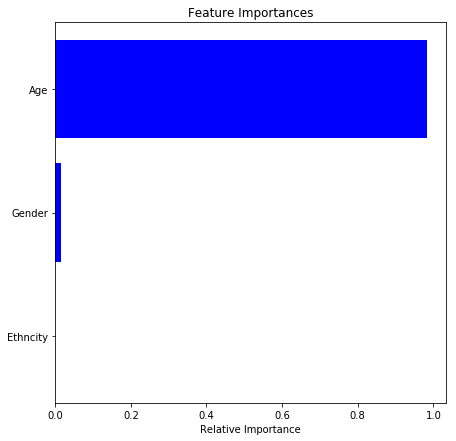

In [35]:
features = X_train.columns
importances = res.best_estimator_.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(7, 7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')